In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import efel

In [3]:
%%capture
!rm -rf x86_64
!nrnivmodl ../mechanisms

In [4]:
from neuron import h
h.load_file("stdrun.hoc");

In [5]:
from glob import glob
cellhocs = sorted(glob('Cell_*.hoc'))
cellhocs

['Cell_0.hoc',
 'Cell_1.hoc',
 'Cell_2.hoc',
 'Cell_3.hoc',
 'Cell_4.hoc',
 'Cell_5.hoc',
 'Cell_6.hoc',
 'Cell_7.hoc',
 'Cell_8.hoc',
 'Cell_9.hoc']

In [6]:
sorted(glob('../morphology/*-var?.swc'))

['../morphology/WT-P270-20-15ak-cor-res3-var0.swc',
 '../morphology/WT-P270-20-15ak-cor-res3-var1.swc',
 '../morphology/WT-P270-20-15ak-cor-res3-var2.swc',
 '../morphology/WT-P270-20-15ak-cor-res3-var3.swc',
 '../morphology/WT-P270-20-15ak-cor-res3-var4.swc',
 '../morphology/WT-P270-20-15ak-cor-res3-var5.swc',
 '../morphology/WT-P270-20-15ak-cor-res3-var6.swc',
 '../morphology/WT-P270-20-15ak-cor-res3-var7.swc',
 '../morphology/WT-P270-20-15ak-cor-res3-var8.swc']

In [7]:
import json
val_models = json.load(open('../val_models.json'))
nmodels = len(val_models)
nmodels

54

In [8]:
nsweeps = 7
rates = np.linspace(1., 8., nsweeps)
simtime = 500
tottime = simtime * nsweeps

In [9]:
def breadth(sec):
    return len(sec.subtree())

def is_terminal(sec):
    return breadth(sec) == 1

def get_terminals(sec):
    return [s for s in sec.subtree() if is_terminal(s)]

In [10]:
cells = []
for morph, hoc in [(x['morph'],f"Cell_{x['par']}.hoc") for x in val_models]:
    #print(f'{hoc=}, {morph=}', flush=True)
    h.load_file(hoc)
    name = hoc.split('.')[0]
    cmd = f'h.{name}("../morphology/", "{morph}")'
    cell = eval(cmd)
    cells.append(cell)

hoc='Cell_0.hoc', morph='WT-P270-20-15ak-cor-res3-var0.swc'
hoc='Cell_1.hoc', morph='WT-P270-20-15ak-cor-res3-var0.swc'
hoc='Cell_2.hoc', morph='WT-P270-20-15ak-cor-res3-var0.swc'
hoc='Cell_3.hoc', morph='WT-P270-20-15ak-cor-res3-var0.swc'
hoc='Cell_4.hoc', morph='WT-P270-20-15ak-cor-res3-var0.swc'
hoc='Cell_5.hoc', morph='WT-P270-20-15ak-cor-res3-var0.swc'
hoc='Cell_7.hoc', morph='WT-P270-20-15ak-cor-res3-var0.swc'
hoc='Cell_8.hoc', morph='WT-P270-20-15ak-cor-res3-var0.swc'
hoc='Cell_9.hoc', morph='WT-P270-20-15ak-cor-res3-var0.swc'
hoc='Cell_0.hoc', morph='WT-P270-20-15ak-cor-res3-var1.swc'
hoc='Cell_1.hoc', morph='WT-P270-20-15ak-cor-res3-var1.swc'
hoc='Cell_2.hoc', morph='WT-P270-20-15ak-cor-res3-var1.swc'
hoc='Cell_3.hoc', morph='WT-P270-20-15ak-cor-res3-var1.swc'
hoc='Cell_4.hoc', morph='WT-P270-20-15ak-cor-res3-var1.swc'
hoc='Cell_5.hoc', morph='WT-P270-20-15ak-cor-res3-var1.swc'
hoc='Cell_6.hoc', morph='WT-P270-20-15ak-cor-res3-var1.swc'
hoc='Cell_7.hoc', morph='WT-P270-20-15ak

In [11]:
def set_syn_stim(rates, simtime, cell, seclist=[], nsyn=10, weight=0.5e-3):
    stimuli = []
    nsts = []
    cons = []
    syns = []
    sections = seclist if seclist else np.random.choice(
        [sec for sec in cell.soma[0].subtree() if 'dend' in sec.name()], 10)

    for sec in sections:
        for i, rate in enumerate(rates):
            for x in np.linspace(0., 1., nsyn):
                ns = h.NetStim()
                ns.interval = 1 / rate * 1e3 if rate else 1e9
                ns.noise = 1.0
                ns.start = simtime * i
                ns.number = int(simtime / ns.interval) + 1
                syn = h.tmGlut(sec(x))
                nc = h.NetCon(ns, syn)
                nc.weight[0] = weight
                cons.append(nc)
                syns.append(syn)
                nsts.append(ns)
                stimuli.append((cons, syns, nsts))
    
    return stimuli

In [12]:
stimuli = []
for cell in cells:
    tips = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
    stimuli.append(set_syn_stim(rates, simtime, cell, tips))

In [13]:
time = h.Vector()
time.record(h._ref_t)

volts = []
for cell in cells:
    volt = h.Vector()
    volt.record(cell.soma[0](0.5)._ref_v)
    volts.append(volt)

In [14]:
h.v_init = -95
h.celsius = 35
h.tstop = tottime

In [15]:
%%time
cvode = h.CVode()
cvode.active(True)
cvode.active(False)
cvode.atol(cvode.atol() * 10)
h.run()

CPU times: user 2h 24min 4s, sys: 16.9 s, total: 2h 24min 21s
Wall time: 2h 24min 1s


0.0

In [16]:
def get_traces(time, volt, step):
    traces = []
    start = 0.0
    end = start + step
    sel = (time >= start) * (time < end)
    while time[sel].any():
        trace = {}
        trace['T'] = time[sel] - start
        trace['V'] = volt[sel]
        trace['stim_start'] = [0.0]
        trace['stim_end'] = [step]
        if len(trace['T']) > 1:
            traces.append(trace)
        start += step
        end += step
        sel = (time >= start) * (time < end)
    return np.array(traces)

In [17]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [18]:
def depol_block(traces):
    blocked = []
    for trace in traces:
        t = trace['T']
        v = trace['V']
        tail = t >= 0.9 * t[-1]
        blocked.append(v[tail].mean() > -50 and v[tail].std() < 10)
    return np.array(blocked)

/tmp/ipykernel_4011/1523952698.py:55: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


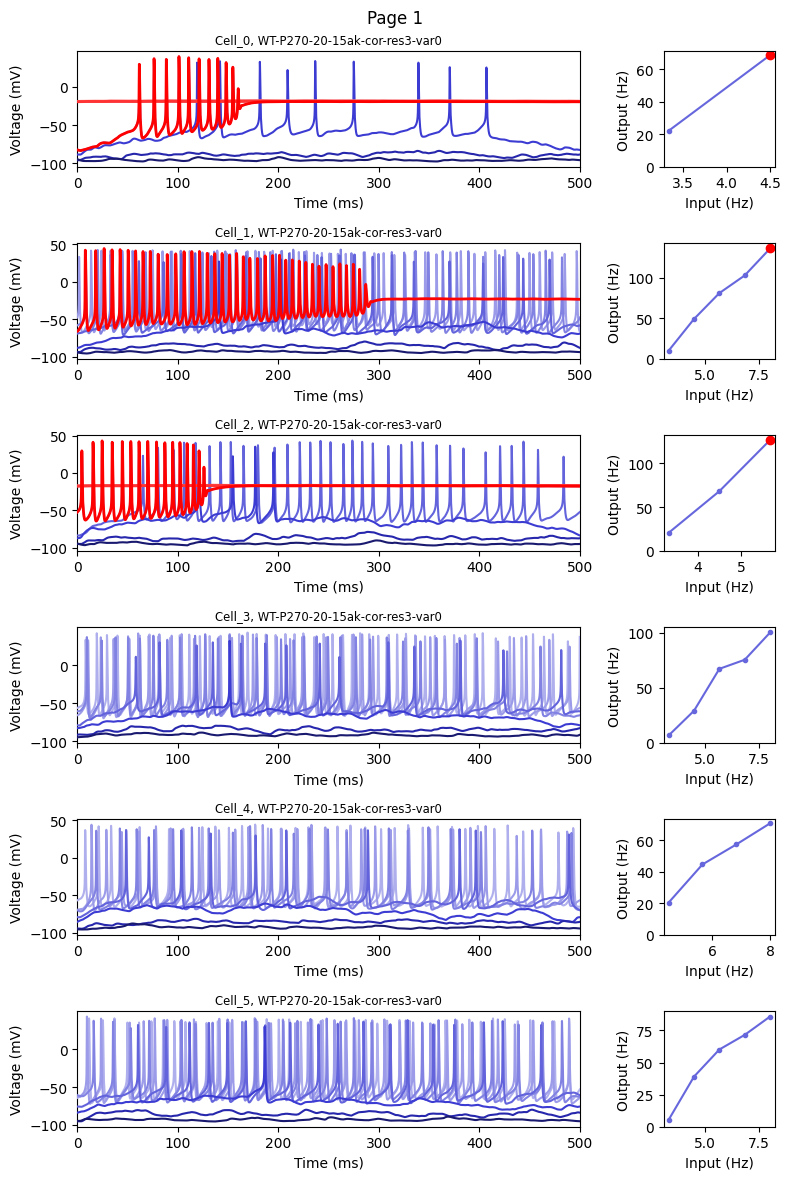

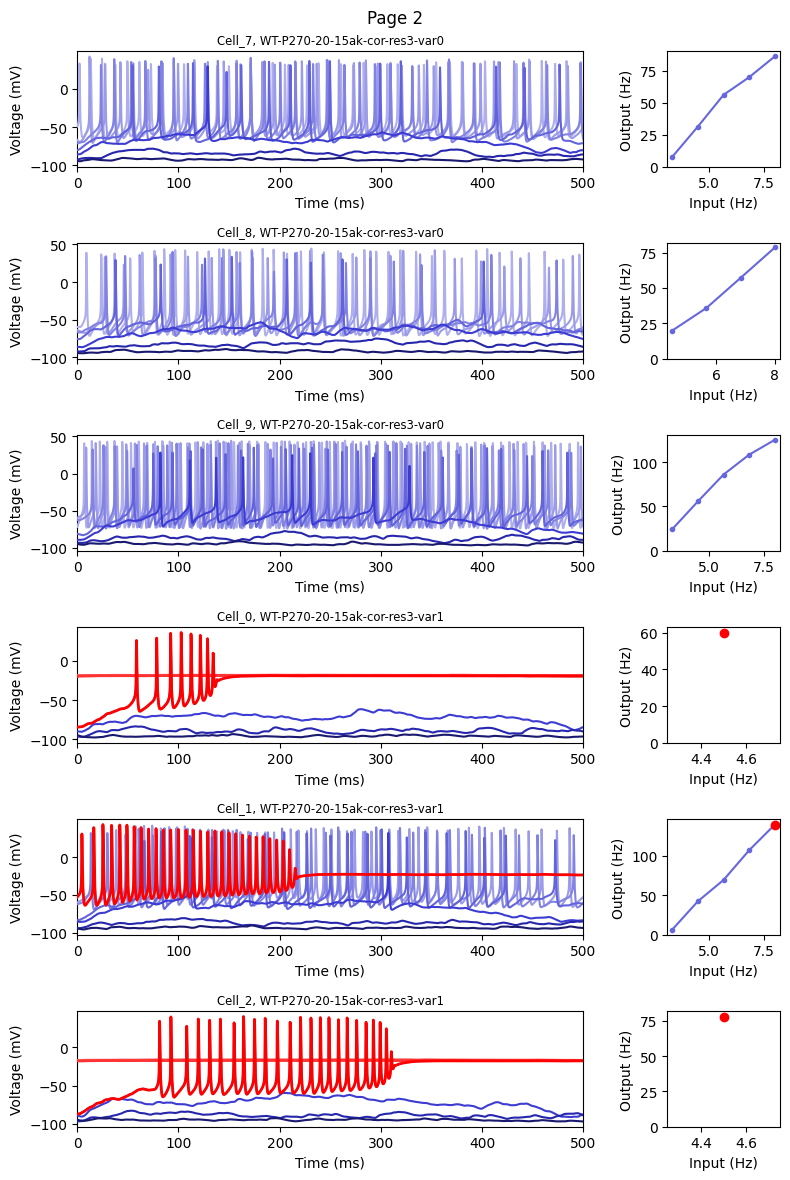

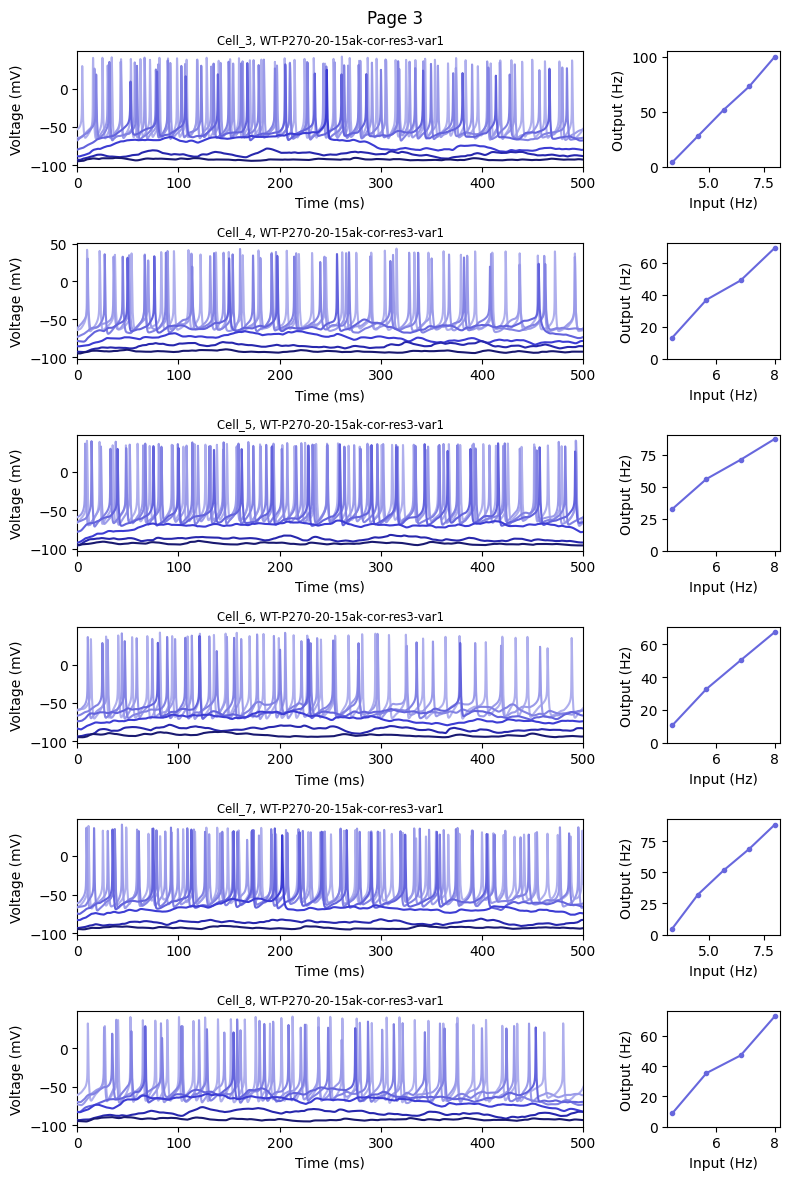

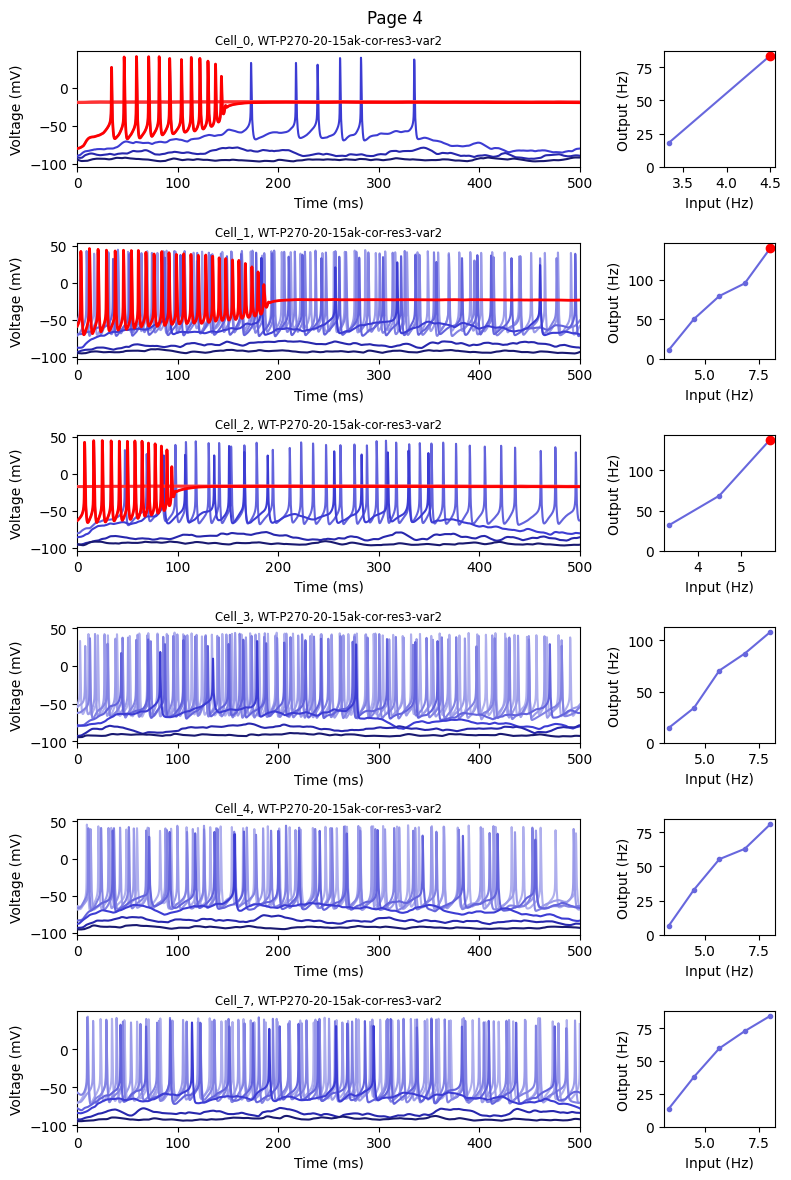

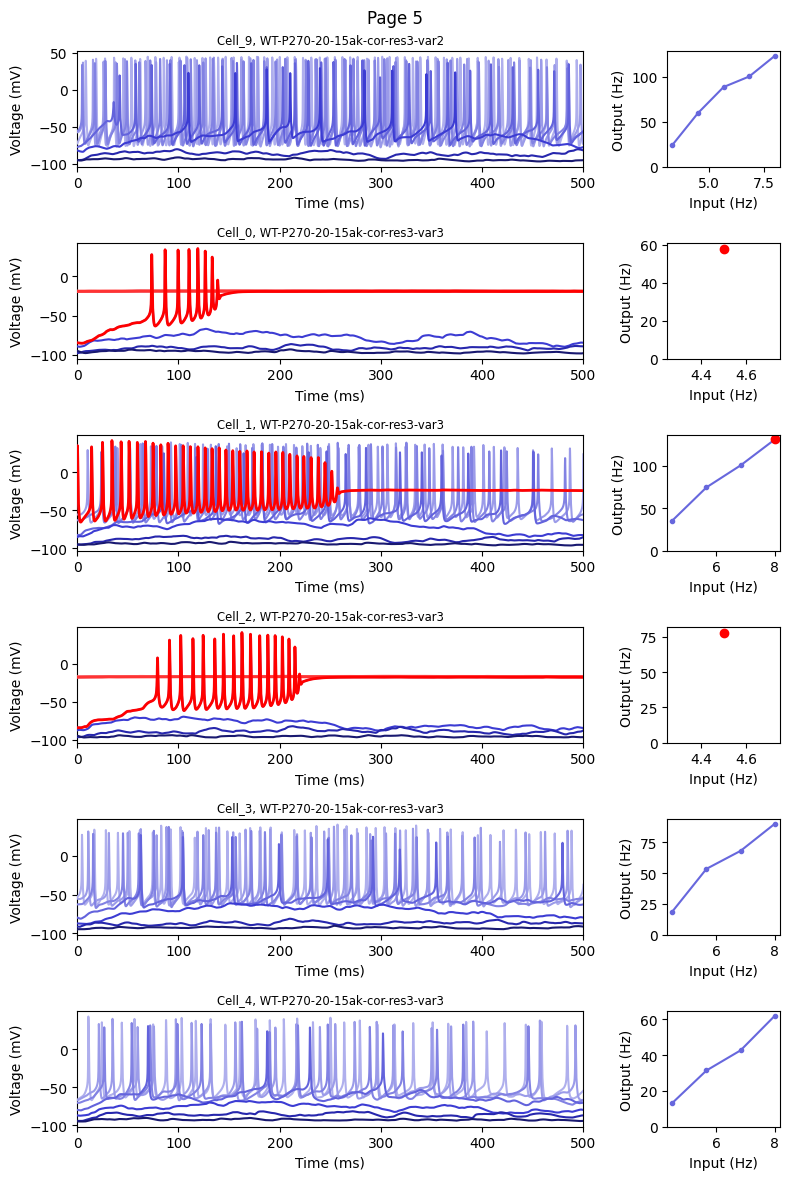

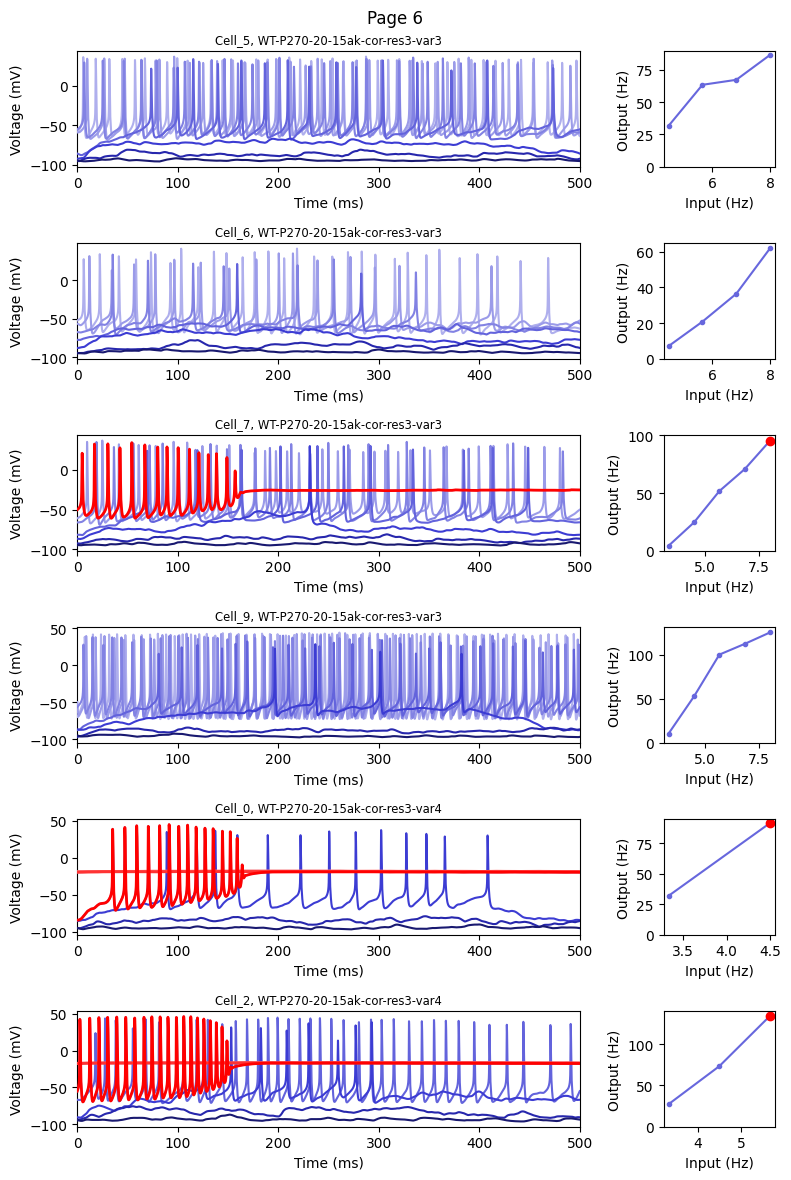

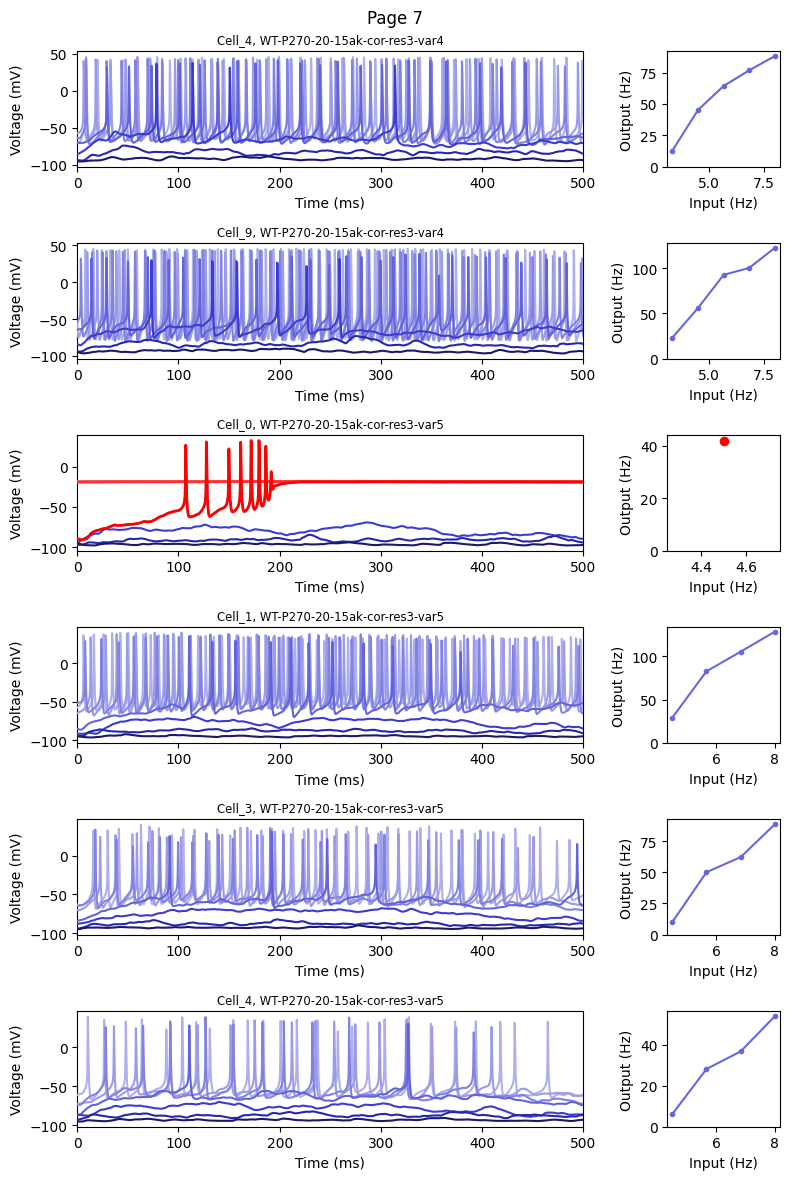

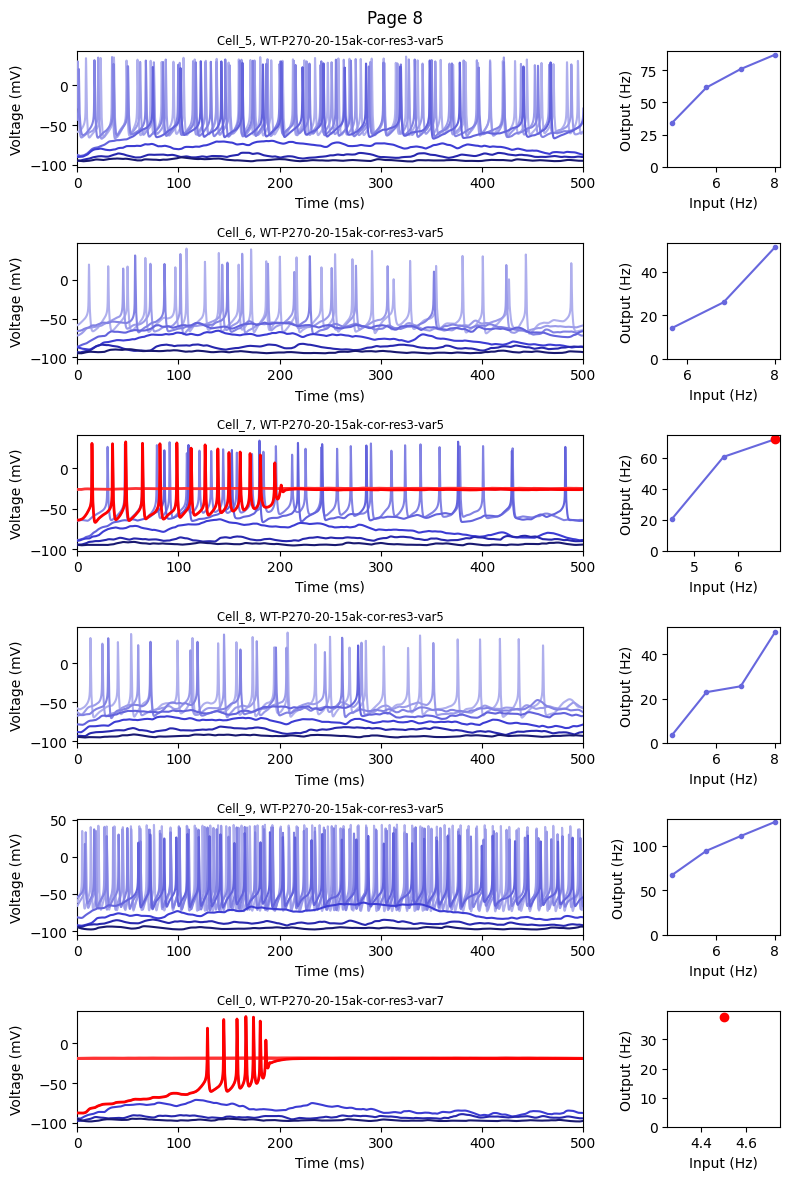

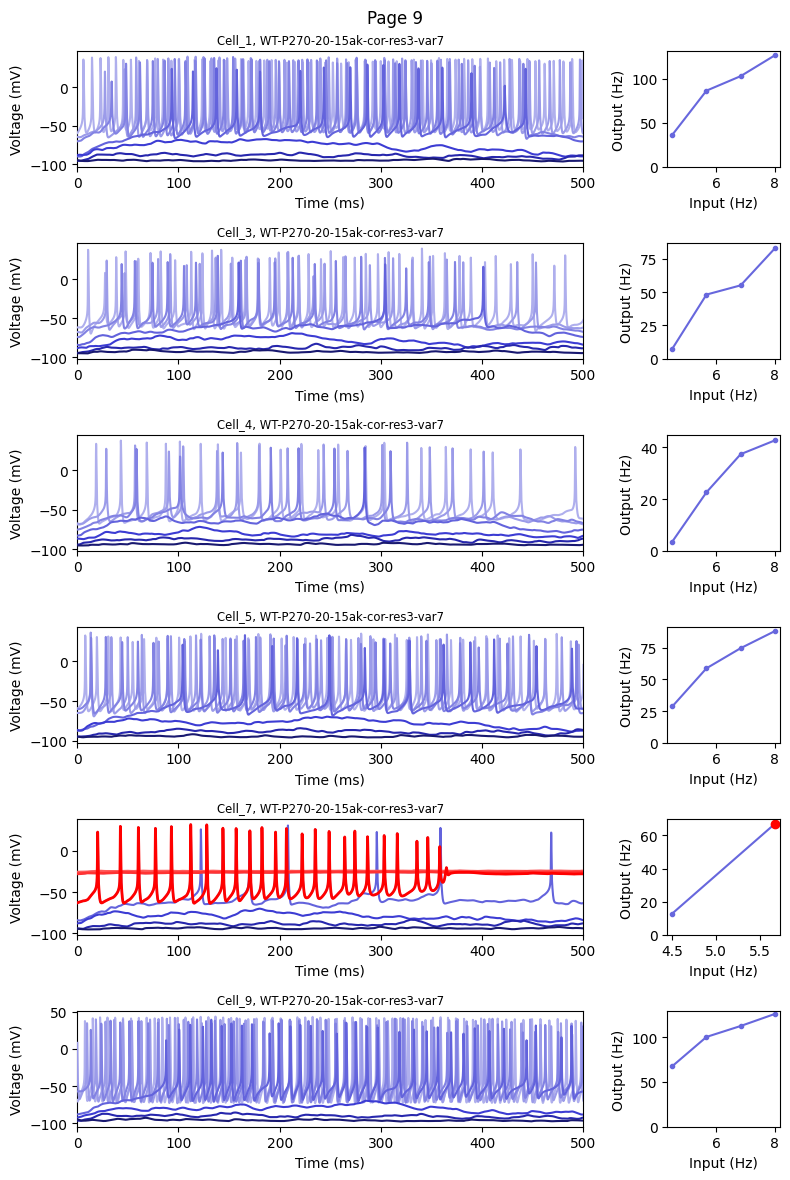

In [19]:
nplots = 6
npages = int(np.ceil(nmodels / nplots))
t = time.as_numpy()
for page in range(npages):
    fig = plt.figure(figsize=(8, 12), constrained_layout=True)
    fig.suptitle(f'Page {page+1}')
    gs = fig.add_gridspec(nplots, 4)
    plot = 0
    selmod = slice(page * nplots, (page + 1) * nplots)
    for model, volt in zip(val_models[selmod], volts[selmod]):
        cellhoc = f"Cell_{model['par']}"
        morph = model['morph'].split('.')[0]
    
        v = volt.as_numpy()
        traces = get_traces(t, v, simtime)

        ax1 = fig.add_subplot(gs[plot, :-1])
        ax1.set_title(f"{cellhoc}, {morph}", size='small')
    
        zorder = 100
        color = 'midnightblue'
        for trace in traces:
            ax1.plot(trace['T'], trace['V'], color=color, zorder=zorder)
            color = lighten_color(color, 0.8)
            zorder -= 1

        zorder += 100
        color = 'red'
        blocked = depol_block(traces)
        for trace in traces[blocked]:
            ax1.plot(trace['T'], trace['V'], color=color, zorder=zorder, lw=2)
            color = lighten_color(color, 0.8)
            zorder -= 1

        ax2 = fig.add_subplot(gs[plot, -1:])

        sp = np.array([x['Spikecount'][0] for x in efel.getFeatureValues(traces, ['Spikecount'])])
        sel = sp > 0
        features = efel.getFeatureValues(traces[sel], ['mean_frequency'])
        inprate = rates[sel]
        outrate = np.array([x['mean_frequency'][0] for x in features])
        ax2.plot(inprate, outrate, '.-', color=lighten_color('midnightblue', 0.5))

        blocked = depol_block(traces[sel])
        if blocked.any():
            ax2.plot(inprate[blocked], outrate[blocked], 'ro')
    
        ax1.set_xlim(0, simtime)
        ax2.set_ylim(bottom=0)
        ax1.set_xlabel('Time (ms)')
        ax1.set_ylabel('Voltage (mV)')
        ax2.set_xlabel('Input (Hz)')
        ax2.set_ylabel('Output (Hz)')
        plot += 1
    fig.tight_layout()
    #fig.savefig(f'dend_syn-{page+1}.png')